# IMERG aggregation

In [2]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [3]:
import ocha_stratus as stratus
import pandas as pd
import geopandas as gpd
import xarray as xr
from tqdm.auto import tqdm
from dask.diagnostics import ProgressBar
from rasterio.errors import RasterioIOError

from src.datasources import codab, imerg
from src.constants import *

## Load data

### CODAB

In [4]:
# codab.download_codab_to_blob()

In [5]:
adm0 = codab.load_codab_from_blob()

In [ ]:
adm0

<Axes: >

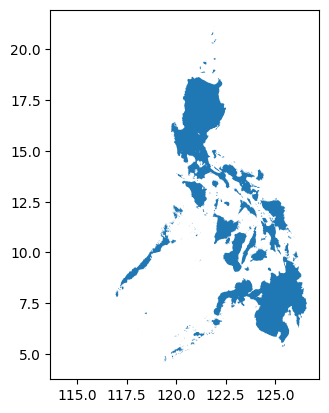

In [9]:
adm0.plot()

### IBTrACS

In [10]:
query = """
SELECT * 
FROM storms.ibtracs_tracks_geo
WHERE basin = 'WP'
"""
with stratus.get_engine(stage="prod").connect() as con:
    gdf_tracks = gpd.read_postgis(query, con, geom_col="geometry")

In [11]:
query = """
SELECT *
FROM storms.ibtracs_storms
"""
with stratus.get_engine(stage="prod").connect() as con:
    df_storms = pd.read_sql(query, con)

In [16]:
gdf_tracks = gdf_tracks.merge(df_storms)

In [21]:
gdf_tracks_recent = gdf_tracks[gdf_tracks["season"] >= 2000].copy()

## Processing

### Filter by distance

In [22]:
adm0_3857 = adm0.to_crs(3857)
target_geom = adm0_3857.geometry.iloc[0]
gdf_tracks_recent_3857 = gdf_tracks_recent.to_crs(3857)

In [23]:
distances = []

for geom in tqdm(gdf_tracks_recent_3857.geometry):
    distances.append(geom.distance(target_geom))

gdf_tracks_recent["distance_m"] = distances

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23093/23093 [05:37<00:00, 68.38it/s]


<Axes: >

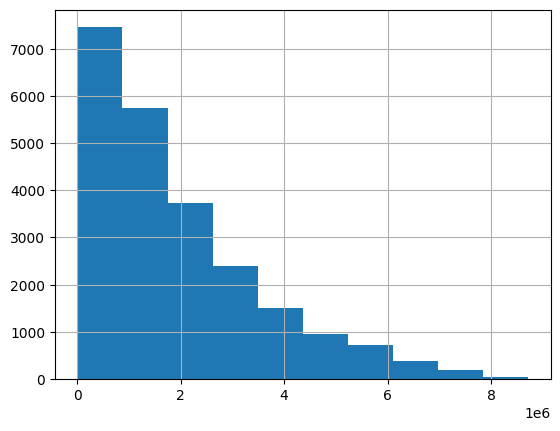

In [26]:
gdf_tracks_recent["distance_m"].hist()

In [27]:
d_thresh = 230

In [ ]:
adm0_3857_buffer230 = adm0_3857.buffer(d_thresh * 1000)

In [30]:
gdf_tracks_close = gdf_tracks_recent[
    gdf_tracks_recent["distance_m"] <= d_thresh * 1000
].copy()

In [37]:
df_tracks_agg = (
    gdf_tracks_close.groupby("sid")
    .agg(
        valid_time_min=("valid_time", "min"),
        valid_time_max=("valid_time", "max"),
        wind_speed_max=("wind_speed", "max"),
    )
    .reset_index()
).dropna()

In [38]:
df_tracks_agg

,sid,valid_time_min,valid_time_max,wind_speed_max
1,2000185N15117,2000-07-03 12:00:00,2000-07-09 00:00:00,65.0
3,2000230N08139,2000-08-22 06:00:00,2000-08-22 12:00:00,110.0
4,2000248N18126,2000-09-10 00:00:00,2000-09-11 12:00:00,45.0
5,2000299N08139,2000-10-27 06:00:00,2000-10-31 18:00:00,75.0
6,2000305N06136,2000-11-01 12:00:00,2000-11-03 18:00:00,55.0
...,...,...,...,...
251,2025262N16133,2025-09-21 18:00:00,2025-09-22 18:00:00,144.0
252,2025267N10134,2025-09-25 12:00:00,2025-09-26 12:00:00,60.0
253,2025274N15131,2025-10-02 12:00:00,2025-10-03 12:00:00,64.0
254,2025291N13126,2025-10-18 00:00:00,2025-10-19 12:00:00,35.0


In [67]:
quantiles = [0.8, 0.9, 0.95]


def get_storm_rainfall_aggregations(row):
    row = row.copy()
    min_date = row["valid_time_min"].date() - pd.DateOffset(days=1)
    max_date = row["valid_time_max"].date() + pd.DateOffset(days=1)
    dates = pd.date_range(min_date, max_date)
    da = imerg.open_imerg_raster_dates(dates)
    da_clip = da.rio.clip(adm0.geometry)

    # 2-day rolling sum
    da_rolling2 = da_clip.rolling(date=2).sum()
    # 3-day rolling sum
    da_rolling3 = da_clip.rolling(date=3).sum()

    # take quantiles
    for quantile in quantiles:
        for da_agg, agg_str in [
            (da_rolling2, "roll2"),
            (da_rolling3, "roll3"),
        ]:
            # get quantile threshs
            quantile_threshs = da_agg.quantile(quantile, dim=["x", "y"])
            # get max value
            row[f"q{quantile*100:.0f}_{agg_str}"] = float(
                quantile_threshs.max()
            )

    return row

In [70]:
import warnings

warnings.filterwarnings("ignore", message="All-NaN slice encountered")

In [71]:
get_storm_rainfall_aggregations(df_tracks_agg.iloc[0])

sid                     2000185N15117
valid_time_min    2000-07-03 12:00:00
valid_time_max    2000-07-09 00:00:00
wind_speed_max                   65.0
q80_roll2                   71.368996
q80_roll3                  102.449005
q90_roll2                  123.287491
q90_roll3                  179.742996
q95_roll2                  162.964005
q95_roll3                   230.12146
Name: 1, dtype: object

In [61]:
tqdm.pandas()

In [72]:
df_tracks_agg = df_tracks_agg.progress_apply(
    get_storm_rainfall_aggregations, axis=1
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [29:57<00:00,  8.90s/it]


In [74]:
blob_name = f"{PROJECT_PREFIX}/processed/ibtracs_imerg_stats.parquet"
stratus.upload_parquet_to_blob(df_tracks_agg, blob_name)